In [1]:
# Aggregation Notebook: Convert per-run JSON results into CSV summaries

import os, glob, json
import pandas as pd
import numpy as np

OUT_DIR = "./outputs"   # change if needed
CSV_DIR = os.path.join(OUT_DIR, "csv")
os.makedirs(CSV_DIR, exist_ok=True)

json_files = sorted(glob.glob(os.path.join(OUT_DIR, "*_results.json")))
print(f"Found {len(json_files)} results files.")
if len(json_files) == 0:
    raise FileNotFoundError("No *_results.json files found in OUT_DIR. Run training notebook first.")


Found 18 results files.


In [2]:
# Load all JSON files
runs = []
for fp in json_files:
    with open(fp, "r") as f:
        runs.append(json.load(f))
print(f"Loaded {len(runs)} runs.")


Loaded 18 runs.


In [3]:
# Build Baseline Summary (one row per dataset–model–seed)
baseline_rows = []
for r in runs:
    c = r["config"]
    b = r["baseline"]
    baseline_rows.append({
        "dataset": c["dataset"],
        "model": c["model_name"],
        "seed": c.get("seed", None),
        "epochs": c["epochs"],
        "batch_size": c["batch_size"],
        "lr": c.get("lr", None),
        "weight_decay": c.get("weight_decay", None),
        "momentum": c.get("momentum", None),
        "test_acc": b["test_acc"],
        "test_loss": b["test_loss"],
        "checkpoint_path": r.get("checkpoint_path", None),
    })

df_baseline = pd.DataFrame(baseline_rows).sort_values(["dataset","model","seed"])
df_baseline.head()


,dataset,model,seed,epochs,batch_size,lr,weight_decay,momentum,test_acc,test_loss,checkpoint_path
9,cifar10,efficientnetv2_s,42,50,64,0.05,0.0001,0.9,0.700700,1.116307,./outputs\cifar10_efficientnetv2_s_e50_bs64.pth
10,cifar10,mobilenetv3_small,42,50,64,0.05,0.0001,0.9,0.717900,1.029419,./outputs\cifar10_mobilenetv3_small_e50_bs64.pth
11,cifar10,shufflenetv2_0_5,42,50,64,0.05,0.0001,0.9,0.721900,0.977214,./outputs\cifar10_shufflenetv2_0_5_e50_bs64.pth
0,cifar10-c,efficientnetv2_s,42,50,64,0.05,0.0001,0.9,0.614574,1.420223,./outputs\cifar10-c_efficientnetv2_s_e50_bs64.pth
1,cifar10-c,mobilenetv3_small,42,50,64,0.05,0.0001,0.9,0.628563,1.326604,./outputs\cifar10-c_mobilenetv3_small_e50_bs64...


In [4]:
# Build Uncertainty Metrics Summary (one row per dataset–model–seed–method)
metric_rows = []
for r in runs:
    c = r["config"]
    um = r["uncertainty_metrics"]
    for method, vals in um.items():
        metric_rows.append({
            "dataset": c["dataset"],
            "model": c["model_name"],
            "seed": c.get("seed", None),
            "method": method,
            "AUROC_error": vals.get("AUROC_error", np.nan),
            "ECE": vals.get("ECE", np.nan),
            "ARC_area": vals.get("ARC_area", np.nan),
            "AvUC": vals.get("AvUC", np.nan),
        })

df_uncert = pd.DataFrame(metric_rows).sort_values(["dataset","model","seed","method"])
df_uncert.head()


,dataset,model,seed,method,AUROC_error,ECE,ARC_area,AvUC
27,cifar10,efficientnetv2_s,42,entropy,0.738755,0.138853,0.816885,0.351642
28,cifar10,efficientnetv2_s,42,gradient,0.775078,0.138853,0.863537,0.298943
29,cifar10,efficientnetv2_s,42,hybrid,0.745628,0.138853,0.823522,0.325293
30,cifar10,mobilenetv3_small,42,entropy,0.740415,0.093129,0.828203,0.352043
31,cifar10,mobilenetv3_small,42,gradient,0.775429,0.093129,0.876536,0.307301


In [5]:
# Build Percentile Rejection Table (one row per dataset–model–seed–method–reject_percent)
rej_rows = []
for r in runs:
    c = r["config"]
    for row in r["percentile_rejection"]:
        rej_rows.append({
            "dataset": c["dataset"],
            "model": c["model_name"],
            "seed": c.get("seed", None),
            "method": row["method"],
            "reject_percent": row["reject_percent"],
            "rejection_rate": row["rejection_rate"],
            "accuracy_before_rejection": row["accuracy_before_rejection"],
            "accuracy_after_rejection": row["accuracy_after_rejection"],
            "kept_count": row.get("kept_count", None),
        })

df_reject = pd.DataFrame(rej_rows).sort_values(["dataset","model","seed","method","reject_percent"])
df_reject.head()


,dataset,model,seed,method,reject_percent,rejection_rate,accuracy_before_rejection,accuracy_after_rejection,kept_count
135,cifar10,efficientnetv2_s,42,entropy,10,0.1,0.7007,0.742000,9000
136,cifar10,efficientnetv2_s,42,entropy,20,0.2,0.7007,0.777750,8000
137,cifar10,efficientnetv2_s,42,entropy,30,0.3,0.7007,0.810857,7000
138,cifar10,efficientnetv2_s,42,entropy,40,0.4,0.7007,0.846167,6000
139,cifar10,efficientnetv2_s,42,entropy,50,0.5,0.7007,0.861600,5000


In [6]:
# Pivot uncertainty metrics (no seed column)
df_pivot = (
    df_uncert
    .groupby(["dataset","model","method"], as_index=False)
    .first()
    .pivot(index=["dataset","model"],
           columns="method",
           values=["AUROC_error","ECE","ARC_area","AvUC"]
        )
    .reset_index()
)

# Flatten columns
df_pivot.columns = [
    col[0] if col[1] == "" else f"{col[0]}_{col[1]}"
    if isinstance(col, tuple) else col
    for col in df_pivot.columns
]

print("Pivot columns after flattening:")
print(df_pivot.columns)

# Merge (without seed)
df_wide = df_baseline.merge(
    df_pivot,
    on=["dataset","model"],
    how="left"
)

print("Final wide shape:", df_wide.shape)
df_wide.head()

Pivot columns after flattening:
Index(['dataset', 'model', 'AUROC_error_entropy', 'AUROC_error_gradient',
       'AUROC_error_hybrid', 'ECE_entropy', 'ECE_gradient', 'ECE_hybrid',
       'ARC_area_entropy', 'ARC_area_gradient', 'ARC_area_hybrid',
       'AvUC_entropy', 'AvUC_gradient', 'AvUC_hybrid'],
      dtype='str')
Final wide shape: (18, 23)


,dataset,model,seed,epochs,batch_size,lr,weight_decay,momentum,test_acc,test_loss,...,AUROC_error_hybrid,ECE_entropy,ECE_gradient,ECE_hybrid,ARC_area_entropy,ARC_area_gradient,ARC_area_hybrid,AvUC_entropy,AvUC_gradient,AvUC_hybrid
0,cifar10,efficientnetv2_s,42,50,64,0.05,0.0001,0.9,0.700700,1.116307,...,0.745628,0.138853,0.138853,0.138853,0.816885,0.863537,0.823522,0.351642,0.298943,0.325293
1,cifar10,mobilenetv3_small,42,50,64,0.05,0.0001,0.9,0.717900,1.029419,...,0.775013,0.093129,0.093129,0.093129,0.828203,0.876536,0.862315,0.352043,0.307301,0.329672
2,cifar10,shufflenetv2_0_5,42,50,64,0.05,0.0001,0.9,0.721900,0.977214,...,0.786194,0.085765,0.085765,0.085765,0.839139,0.888165,0.865912,0.355744,0.284766,0.320255
3,cifar10-c,efficientnetv2_s,42,50,64,0.05,0.0001,0.9,0.614574,1.420223,...,0.724838,0.199720,0.199720,0.199720,0.742015,0.792660,0.744365,0.390801,0.384656,0.387728
4,cifar10-c,mobilenetv3_small,42,50,64,0.05,0.0001,0.9,0.628563,1.326604,...,0.751644,0.152954,0.152954,0.152954,0.755496,0.807410,0.790865,0.386114,0.367603,0.376858


In [7]:
# Save CSV files
baseline_csv = os.path.join(CSV_DIR, "baseline_summary.csv")
uncert_csv = os.path.join(CSV_DIR, "uncertainty_metrics.csv")
reject_csv = os.path.join(CSV_DIR, "percentile_rejection.csv")
wide_csv = os.path.join(CSV_DIR, "thesis_wide_summary.csv")

df_baseline.to_csv(baseline_csv, index=False)
df_uncert.to_csv(uncert_csv, index=False)
df_reject.to_csv(reject_csv, index=False)
df_wide.to_csv(wide_csv, index=False)

print("Saved:")
print(" -", baseline_csv)
print(" -", uncert_csv)
print(" -", reject_csv)
print(" -", wide_csv)

Saved:
 - ./outputs\csv\baseline_summary.csv
 - ./outputs\csv\uncertainty_metrics.csv
 - ./outputs\csv\percentile_rejection.csv
 - ./outputs\csv\thesis_wide_summary.csv


In [ ]:
# Plots
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Where to save figures
FIG_DIR = "./outputs/figures"
os.makedirs(FIG_DIR, exist_ok=True)

def save_fig(fig, filename_base):
    png = os.path.join(FIG_DIR, f"{filename_base}.png")
    pdf = os.path.join(FIG_DIR, f"{filename_base}.pdf")
    fig.tight_layout()
    fig.savefig(png, dpi=300, bbox_inches="tight")
    fig.savefig(pdf, bbox_inches="tight")
    plt.close(fig)
    return png, pdf

def _clean_method_labels(s):
    s = str(s)
    # handle both possible gradient method names
    s = s.replace("gradnorm", "Gradient").replace("gradient", "Gradient")
    s = s.replace("entropy", "Entropy").replace("hybrid", "Hybrid")
    return s

In [ ]:
df_baseline = pd.read_csv("./outputs/csv/baseline_summary.csv")
df_uncert   = pd.read_csv("./outputs/csv/uncertainty_metrics.csv")
df_reject   = pd.read_csv("./outputs/csv/percentile_rejection.csv")

# Normalize raw method codes for consistency
df_uncert["method"] = df_uncert["method"].replace({"gradient": "gradnorm"})
df_reject["method"] = df_reject["method"].replace({"gradient": "gradnorm"})

# Normalize naming
df_uncert["method_display"] = df_uncert["method"].map(_clean_method_labels)
df_reject["method_display"] = df_reject["method"].map(_clean_method_labels)

df_baseline.head(), df_uncert.head(), df_reject.head()

(     dataset              model  seed  epochs  batch_size    lr  weight_decay  \
 0    cifar10   efficientnetv2_s    42      50          64  0.05        0.0001   
 1    cifar10  mobilenetv3_small    42      50          64  0.05        0.0001   
 2    cifar10   shufflenetv2_0_5    42      50          64  0.05        0.0001   
 3  cifar10-c   efficientnetv2_s    42      50          64  0.05        0.0001   
 4  cifar10-c  mobilenetv3_small    42      50          64  0.05        0.0001   
 
    momentum  test_acc  test_loss  \
 0       0.9  0.700700   1.116307   
 1       0.9  0.717900   1.029419   
 2       0.9  0.721900   0.977214   
 3       0.9  0.614574   1.420223   
 4       0.9  0.628563   1.326604   
 
                                      checkpoint_path  
 0    ./outputs\cifar10_efficientnetv2_s_e50_bs64.pth  
 1   ./outputs\cifar10_mobilenetv3_small_e50_bs64.pth  
 2    ./outputs\cifar10_shufflenetv2_0_5_e50_bs64.pth  
 3  ./outputs\cifar10-c_efficientnetv2_s_e50_bs64.pth  
 4

In [10]:
def plot_avuc_bars(df_uncert):
    # Skip if AvUC column doesn't exist
    if "AvUC" not in df_uncert.columns:
        print("AvUC column not found in data. Skipping AvUC plots.")
        return
        
    for (dataset, model), g in df_uncert.groupby(["dataset", "model"], sort=False):
        summary = g.groupby("method", as_index=False)["AvUC"].mean()

        fig = plt.figure()
        ax = plt.gca()
        ax.bar(summary["method"], summary["AvUC"])
        ax.set_ylabel("AvUC (Lower is Better)")
        ax.set_title(f"AvUC by Method — {dataset} / {model}")
        ax.grid(axis="y", alpha=0.3)

        save_fig(fig, f"AvUC_{dataset}_{model}")

plot_avuc_bars(df_uncert)
print(f"Saved AvUC plots to: {FIG_DIR}")

Saved AvUC plots to: ./outputs/figures


In [11]:
def plot_metric_multipanel_by_model(
    df_uncert: pd.DataFrame,
    metric_col: str,
    fig_name: str,
    title_metric: str,
    datasets_base=("cifar10", "cifar100", "tinyimagenet"),
    models=("shufflenetv2_0_5", "mobilenetv3_small", "efficientnetv2_s"),
    methods=("entropy", "gradnorm", "hybrid"),
):
    """
    Multi-panel bar chart: one subplot per model, x-axis = dataset (base),
    bars = methods (entropy/gradnorm/hybrid).
    Produces two figures: clean and corrupted (-c).

    Expected df_uncert columns:
      - dataset, model, method, metric_col (e.g., AUROC_error or ARC_area)
      - seed optional
    """

    required = {"dataset", "model", "method", metric_col}
    missing = required - set(df_uncert.columns)
    if missing:
        print(f"[SKIP] Missing columns for {fig_name}: {missing}")
        return

    # Normalize dataset to (base_dataset, regime)
    df = df_uncert.copy()
    df["regime"] = np.where(df["dataset"].astype(str).str.endswith("-c"), "corrupted", "clean")
    df["dataset_base"] = df["dataset"].astype(str).str.replace("-c", "", regex=False)

    # Only keep target datasets/models/methods
    df = df[df["dataset_base"].isin(datasets_base)]
    df = df[df["model"].isin(models)]
    df = df[df["method"].isin(methods)]

    # Human-friendly labels
    dataset_label = {
        "cifar10": "CIFAR-10",
        "cifar100": "CIFAR-100",
        "tinyimagenet": "Tiny ImageNet",
    }
    model_label = {
        "shufflenetv2_0_5": "ShuffleNetV2 (0.5×)",
        "mobilenetv3_small": "MobileNetV3-Small",
        "efficientnetv2_s": "EfficientNetV2-S",
    }
    method_label = {
        "entropy": "Entropy",
        "gradnorm": "Gradient",
        "hybrid": "Hybrid",
    }

    def _plot_for_regime(regime: str):
        df_r = df[df["regime"] == regime]
        if df_r.empty:
            print(f"[SKIP] No data for {fig_name} ({regime}).")
            return

        # Aggregate over seeds if present
        # Using mean is safe; you can switch to median later if needed
        summary = (
            df_r.groupby(["model", "dataset_base", "method"], as_index=False)[metric_col]
            .mean()
        )

        fig, axes = plt.subplots(1, len(models), figsize=(16, 4), sharey=True)
        if len(models) == 1:
            axes = [axes]

        x = np.arange(len(datasets_base))
        width = 0.25  # 3 methods

        for ax, m in zip(axes, models):
            g = summary[summary["model"] == m]
            if g.empty:
                ax.set_title(model_label.get(m, m))
                ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
                ax.axis("off")
                continue

            # Ensure consistent method order
            for i, method in enumerate(methods):
                vals = []
                for d in datasets_base:
                    row = g[(g["dataset_base"] == d) & (g["method"] == method)]
                    vals.append(row[metric_col].iloc[0] if len(row) else np.nan)

                ax.bar(x + (i - 1) * width, vals, width, label=method_label.get(method, method))

            ax.set_title(model_label.get(m, m))
            ax.set_xticks(x)
            ax.set_xticklabels([dataset_label.get(d, d) for d in datasets_base], rotation=0)
            ax.set_ylim(0.0, 1.0)
            ax.grid(axis="y", alpha=0.25)

        fig.suptitle(f"{title_metric} by Dataset ({regime.capitalize()})", y=1.05)
        axes[0].set_ylabel(title_metric)
        axes[-1].legend(loc="lower right")

        save_fig(fig, f"{fig_name}_{regime}.png")

    _plot_for_regime("clean")
    _plot_for_regime("corrupted")

In [12]:
def plot_ece_bars(df_uncert):
    for (dataset, model), g in df_uncert.groupby(["dataset", "model"], sort=False):
        summary = g.groupby("method", as_index=False)["ECE"].mean()

        fig = plt.figure()
        ax = plt.gca()

        ax.bar(summary["method"], summary["ECE"])
        ax.set_ylabel("ECE (Lower is Better)")
        ax.set_title(f"ECE by Method — {dataset} / {model}")
        ax.grid(axis="y", alpha=0.3)

        save_fig(fig, f"ECE_{dataset}_{model}")

plot_ece_bars(df_uncert)
print(f"Saved ECE plots to: {FIG_DIR}")

Saved ECE plots to: ./outputs/figures


In [13]:
def plot_auroc_multipanel(df_uncert: pd.DataFrame):
    plot_metric_multipanel_by_model(
        df_uncert=df_uncert,
        metric_col="AUROC_error",
        fig_name="auroc_multipanel",
        title_metric="AUROC (Error Detection)",
    )

def plot_arc_multipanel(df_uncert: pd.DataFrame):
    plot_metric_multipanel_by_model(
        df_uncert=df_uncert,
        metric_col="ARC_area",
        fig_name="arc_multipanel",
        title_metric="ARC Area (Selective Prediction)",
    )

plot_auroc_multipanel(df_uncert)
plot_arc_multipanel(df_uncert)

print("Done. Figures saved to:", FIG_DIR)

Done. Figures saved to: ./outputs/figures


In [14]:
def plot_rejection_curves(df_reject):
    # Expect columns: dataset, model, seed, method, reject_percent, accuracy_after_rejection, accuracy_before_rejection
    for (dataset, model), g in df_reject.groupby(["dataset", "model"], sort=False):
        fig = plt.figure()
        ax = plt.gca()

        # Plot one line per method
        for method, gm in g.groupby("method", sort=False):
            gm = gm.sort_values("reject_percent")
            ax.plot(gm["reject_percent"], gm["accuracy_after_rejection"], marker="o", label=method)

        # Baseline line (accuracy before rejection)
        base_acc = float(g["accuracy_before_rejection"].iloc[0])
        ax.axhline(base_acc, linestyle="--", linewidth=1.0, label="Baseline (No Rejection)")

        ax.set_xlabel("Rejected Most-Uncertain Samples (%)")
        ax.set_ylabel("Accuracy on Kept Samples")
        ax.set_title(f"Accuracy vs Rejection — {dataset} / {model}")
        ax.grid(alpha=0.3)
        ax.legend()

        save_fig(fig, f"RejectionCurve_{dataset}_{model}")

plot_rejection_curves(df_reject)
print(f"Saved rejection curves to: {FIG_DIR}")

Saved rejection curves to: ./outputs/figures


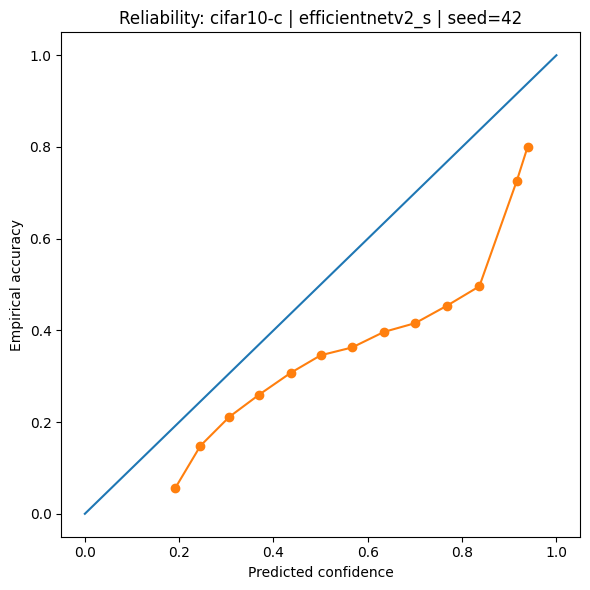

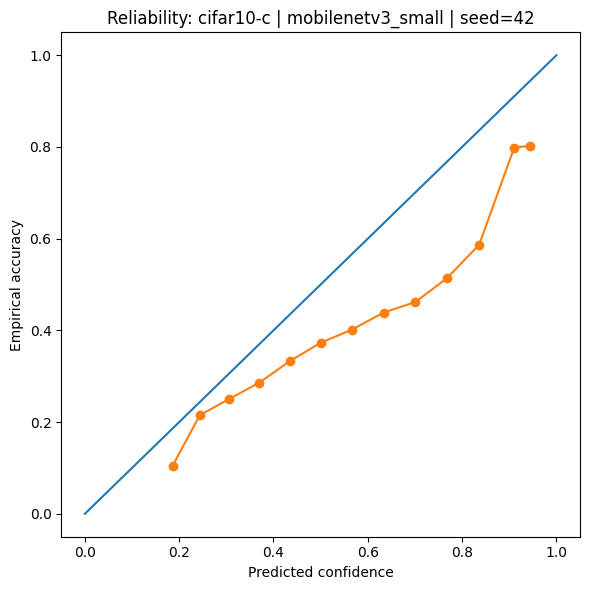

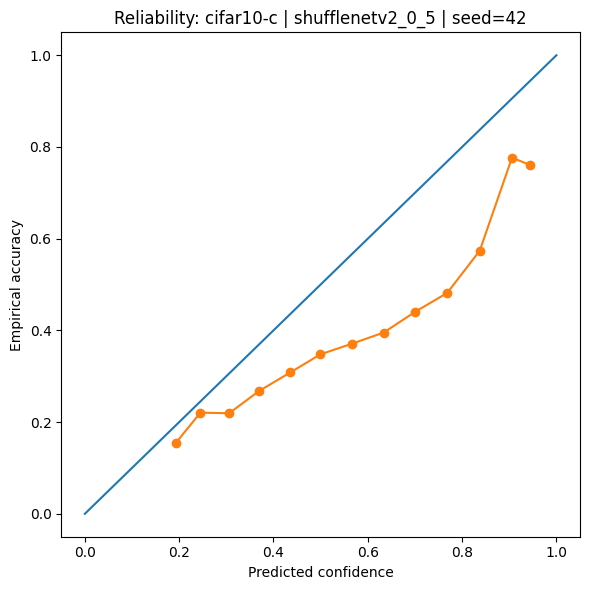

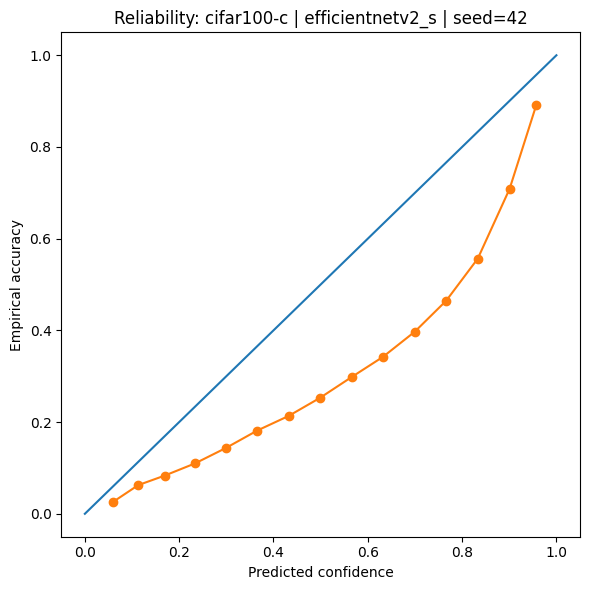

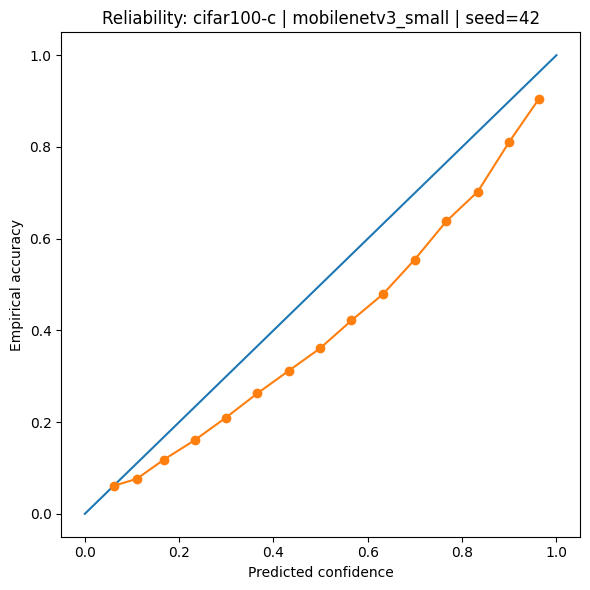

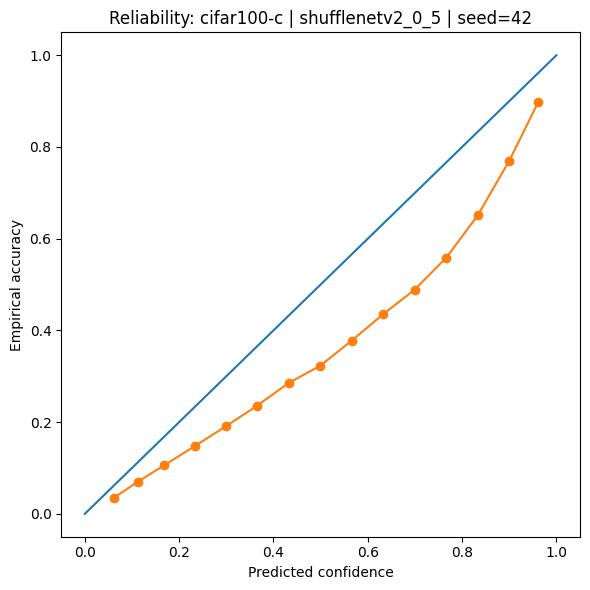

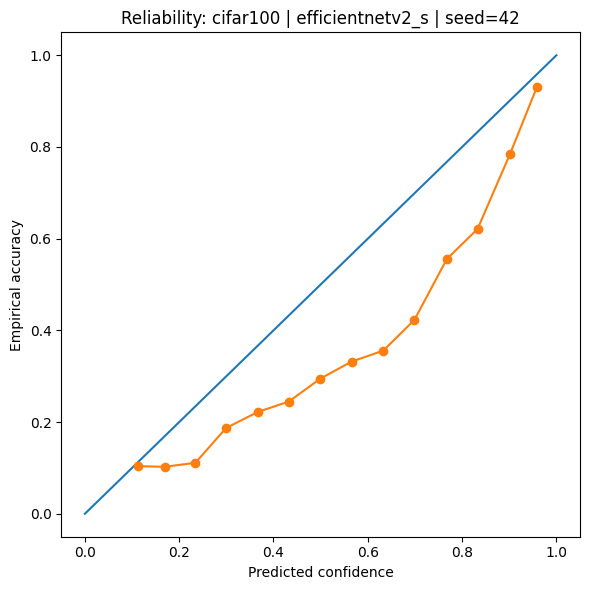

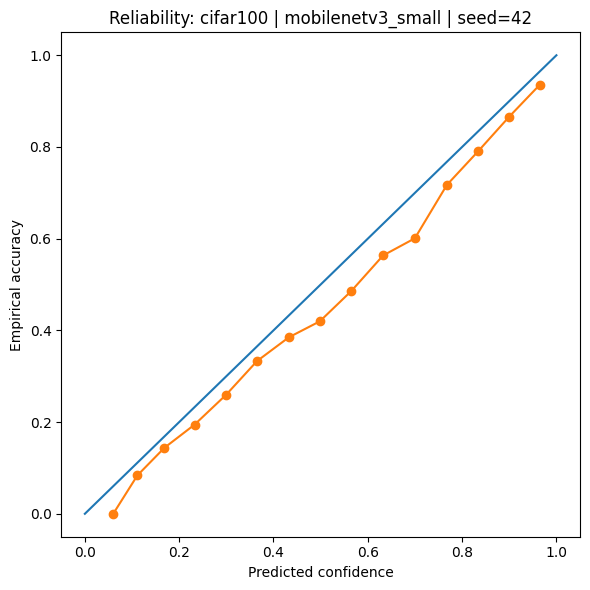

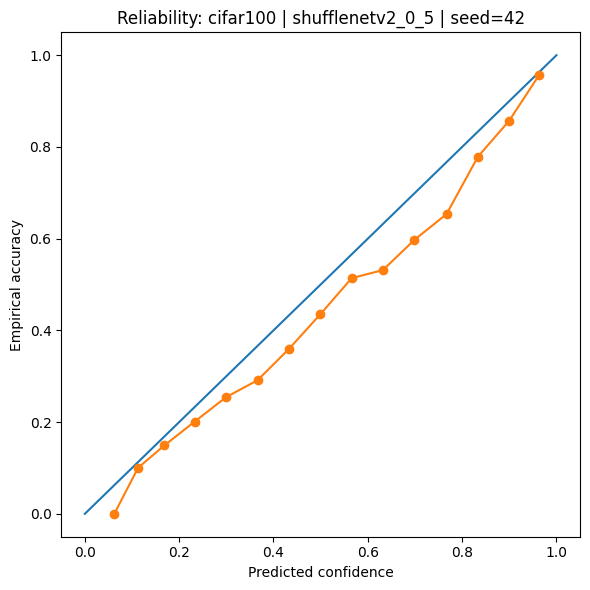

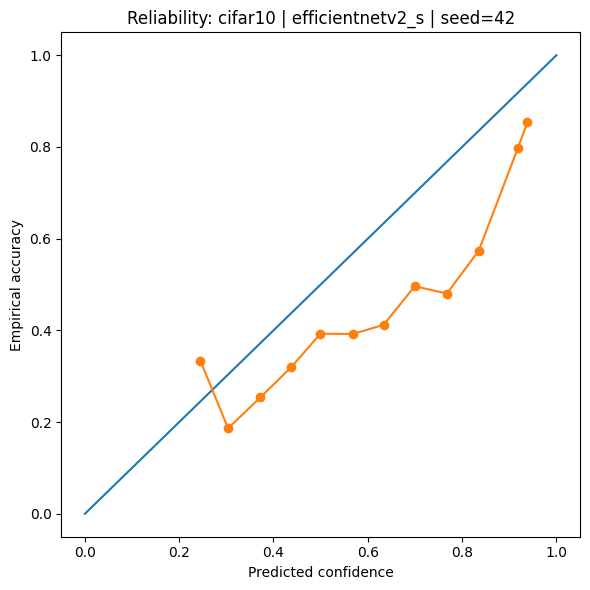

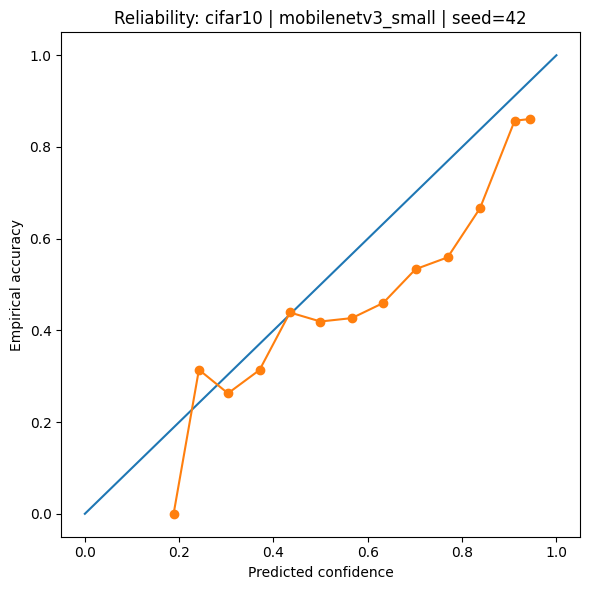

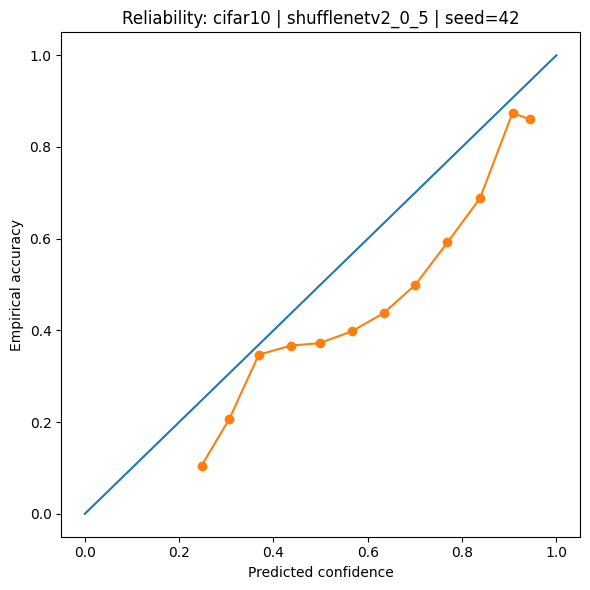

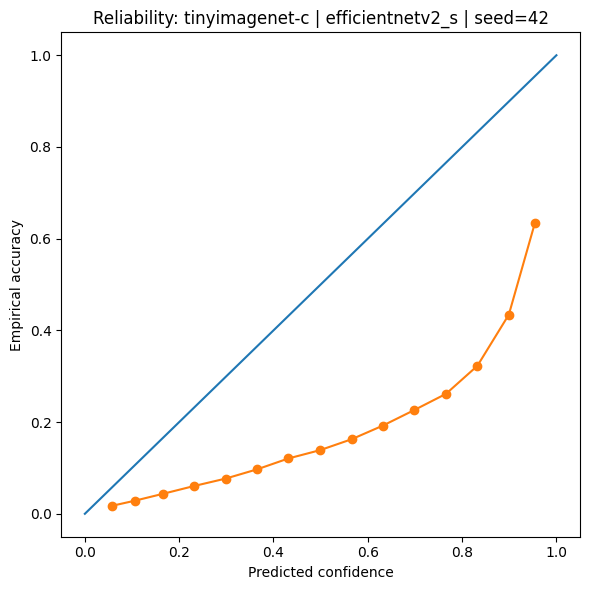

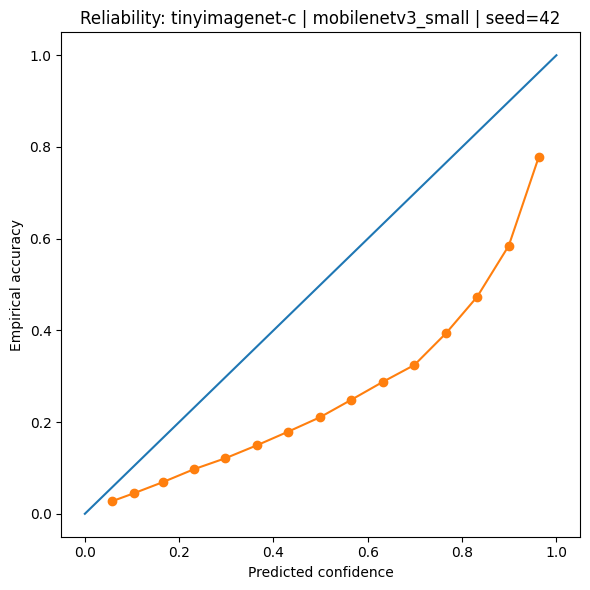

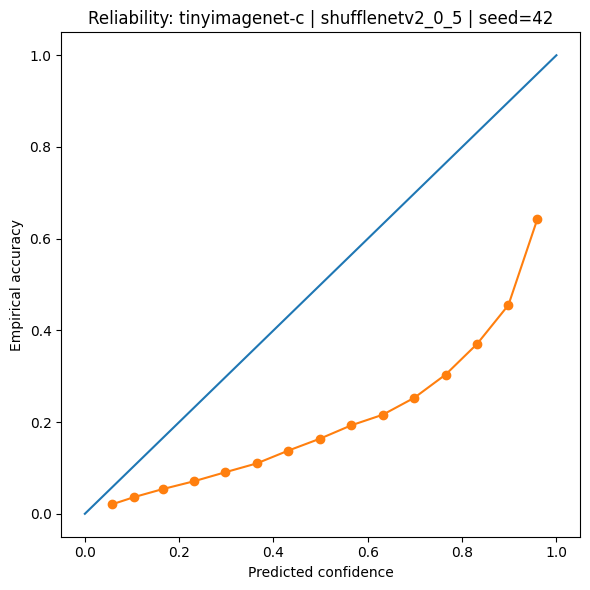

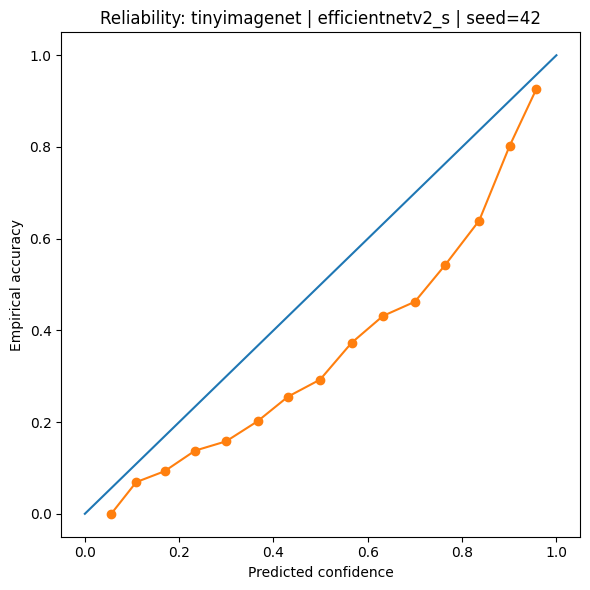

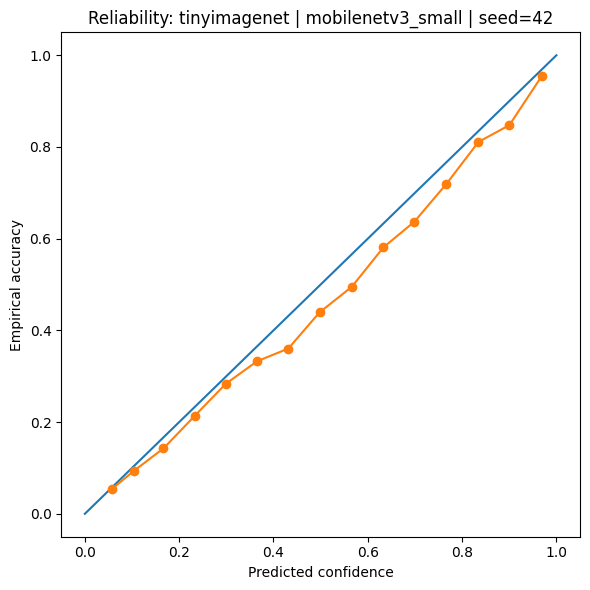

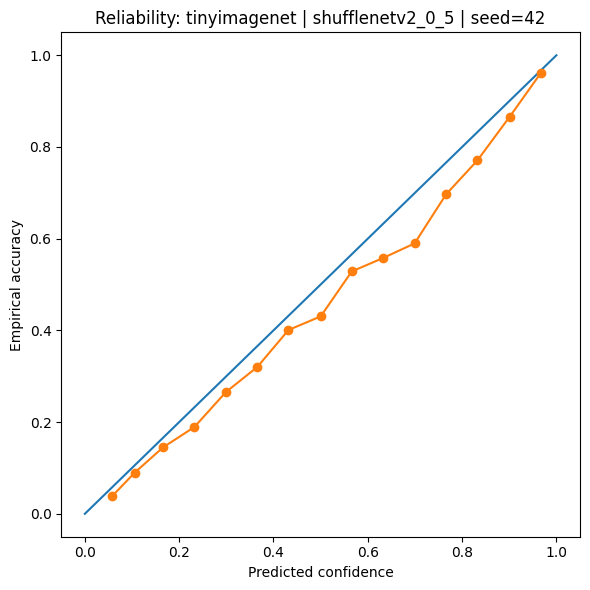

Saved reliability diagrams to: ./outputs/figures


In [15]:
def plot_reliability_diagrams(runs):
    for r in runs:
        rel = r.get("reliability", None)
        if rel is None:
            continue

        cfg = r["config"]
        dataset = cfg["dataset"]
        model = cfg["model_name"]
        seed = cfg.get("seed", None)

        edges = np.array(rel["edges"], dtype=float)
        bin_conf = np.array(rel["bin_conf"], dtype=float)
        bin_acc = np.array(rel["bin_acc"], dtype=float)

        mask = ~np.isnan(bin_conf) & ~np.isnan(bin_acc)
        bin_conf = bin_conf[mask]
        bin_acc = bin_acc[mask]

        plt.figure(figsize=(6, 6))
        plt.plot([0, 1], [0, 1])
        plt.plot(bin_conf, bin_acc, marker="o")
        plt.xlabel("Predicted confidence")
        plt.ylabel("Empirical accuracy")
        plt.title(f"Reliability: {dataset} | {model} | seed={seed}")

        out_path = os.path.join(FIG_DIR, f"reliability_{dataset}_{model}_seed{seed}.png")
        plt.tight_layout()
        plt.savefig(out_path, dpi=200)
        plt.show()

plot_reliability_diagrams(runs)
print(f"Saved reliability diagrams to: {FIG_DIR}")

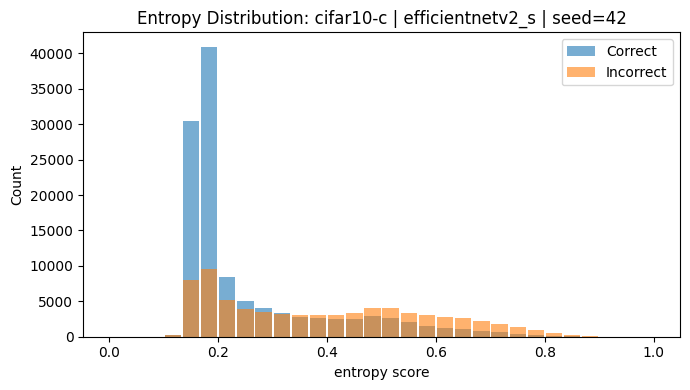

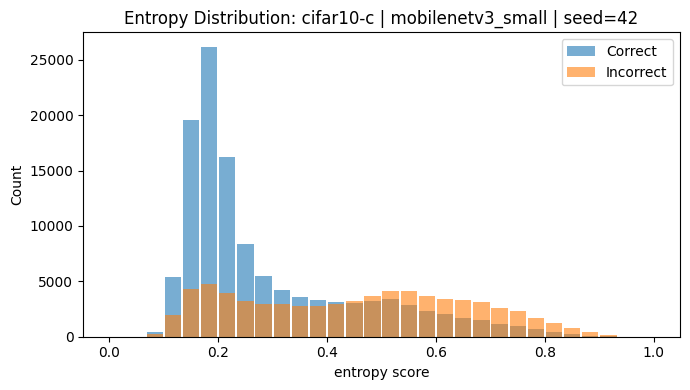

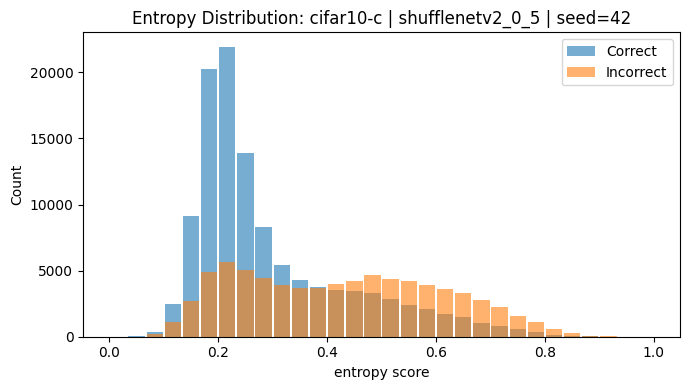

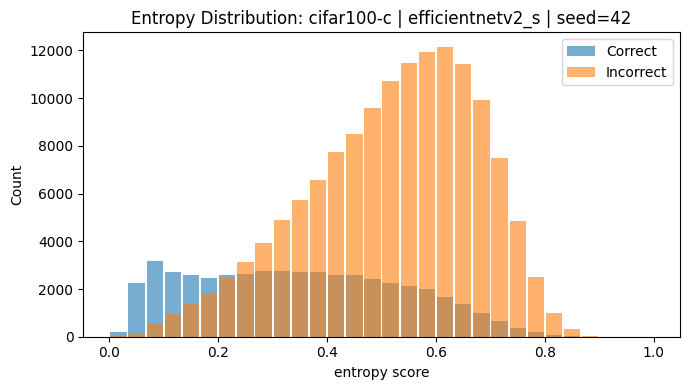

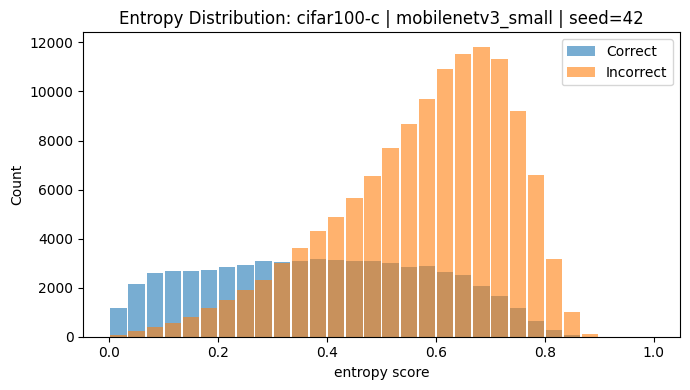

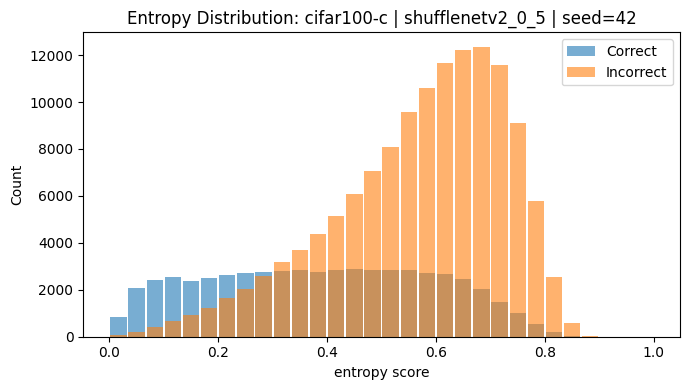

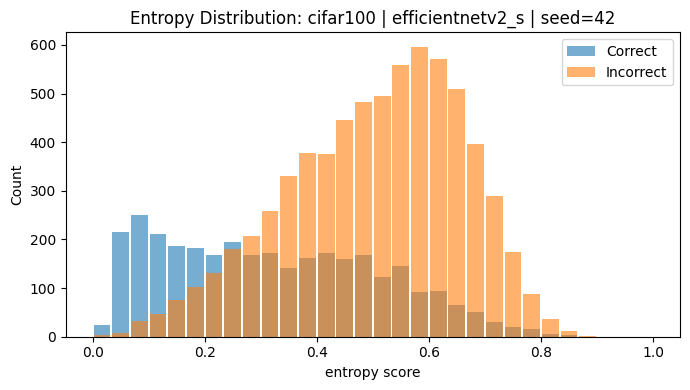

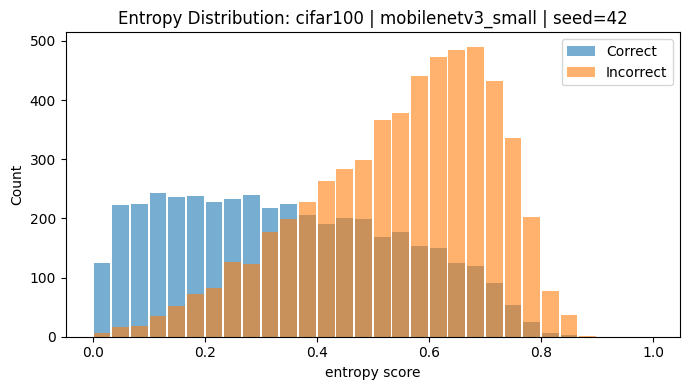

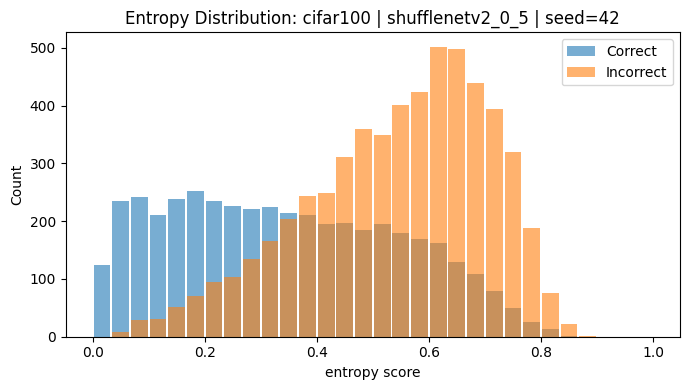

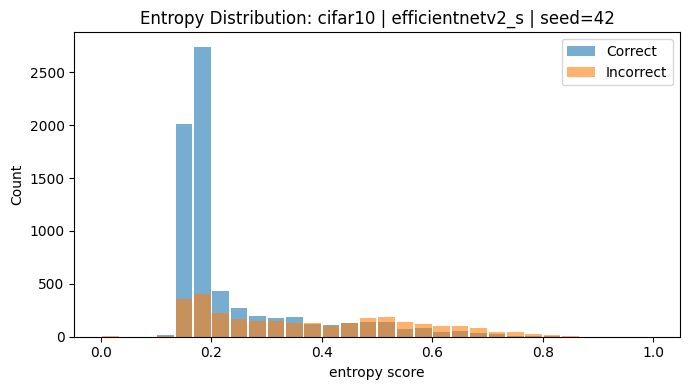

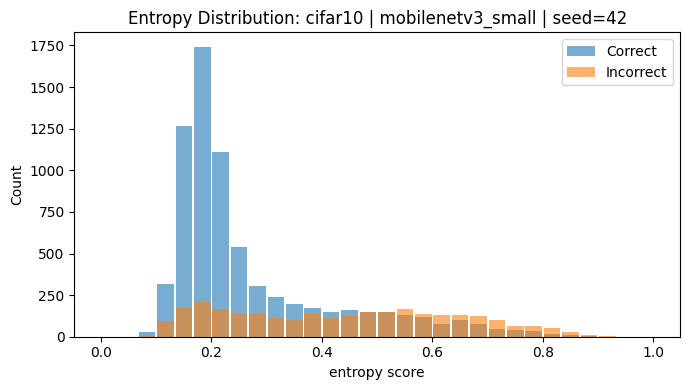

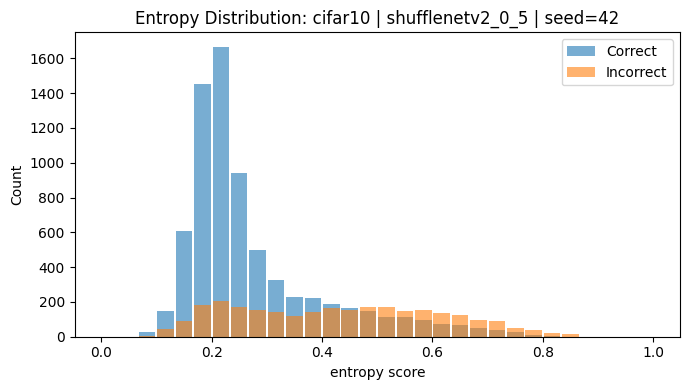

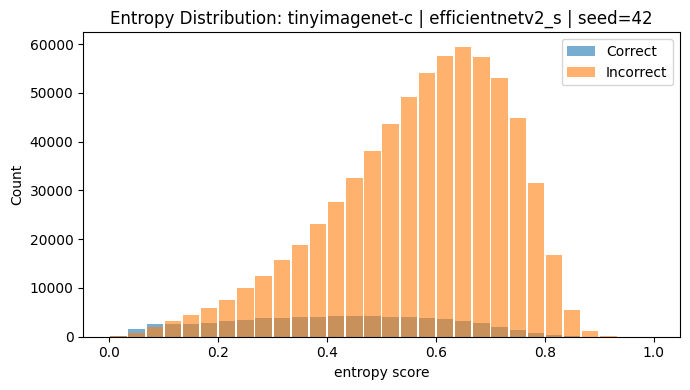

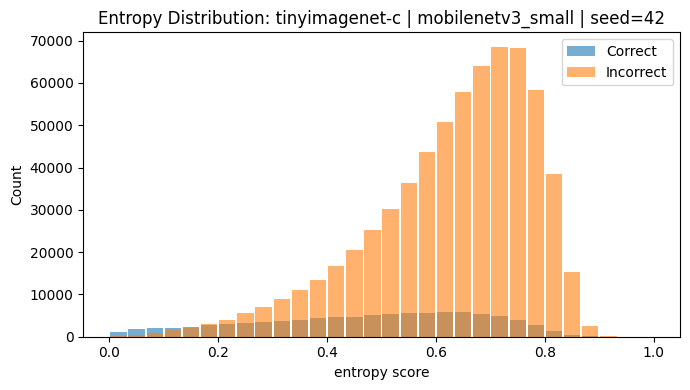

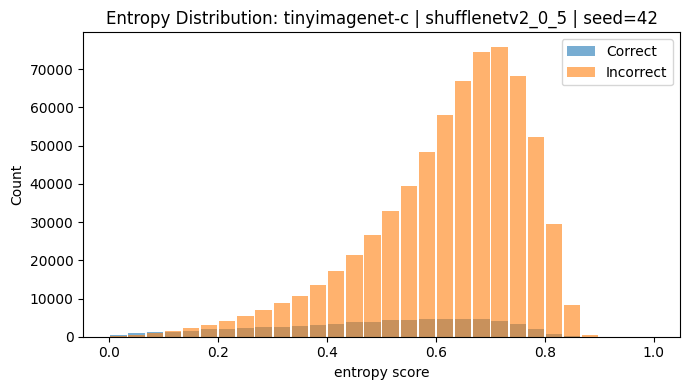

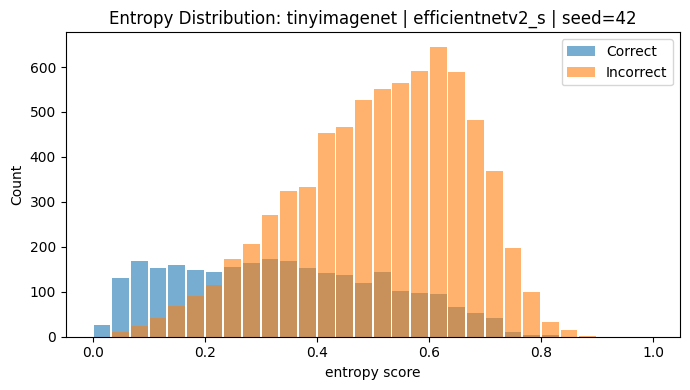

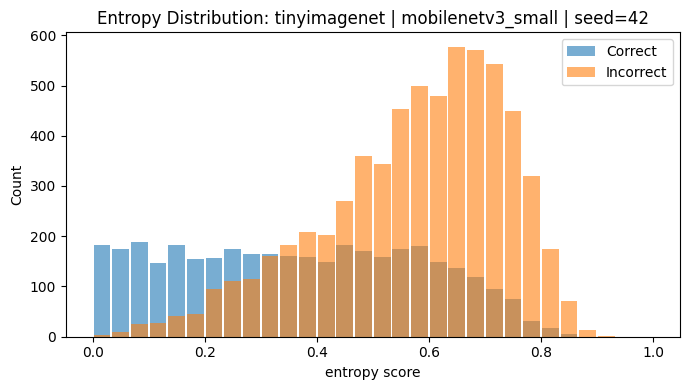

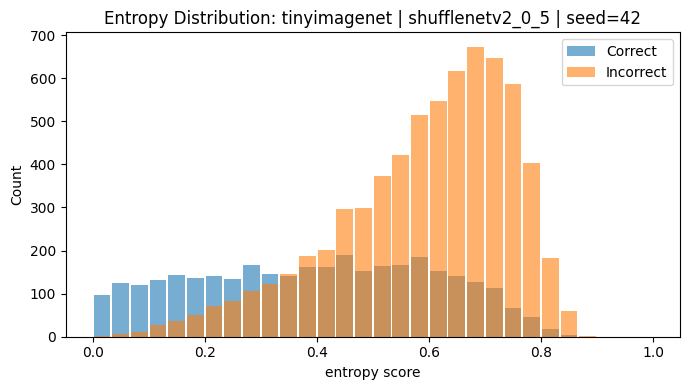

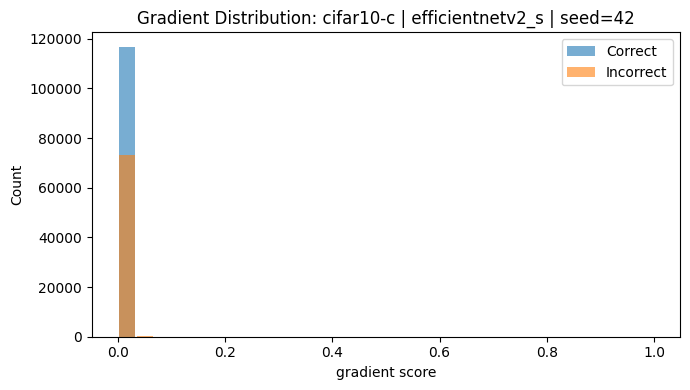

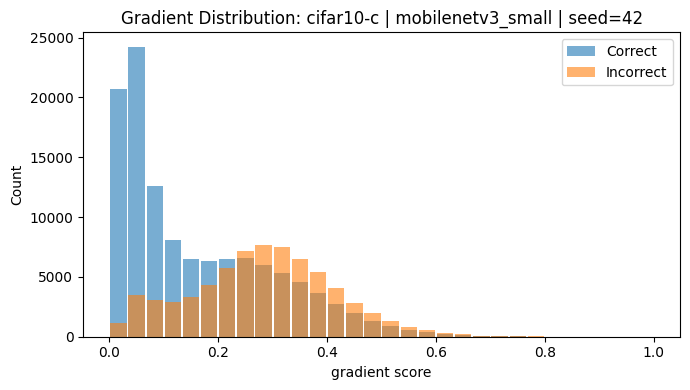

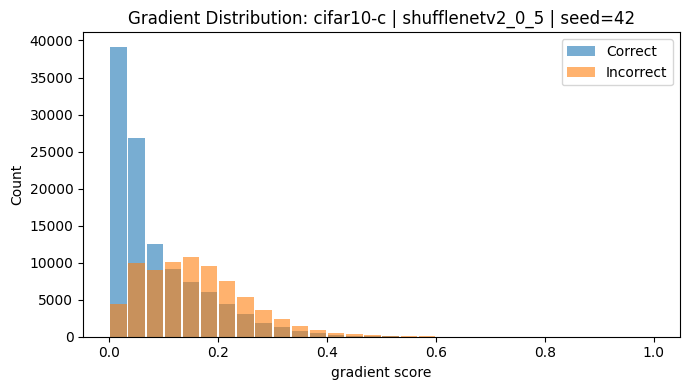

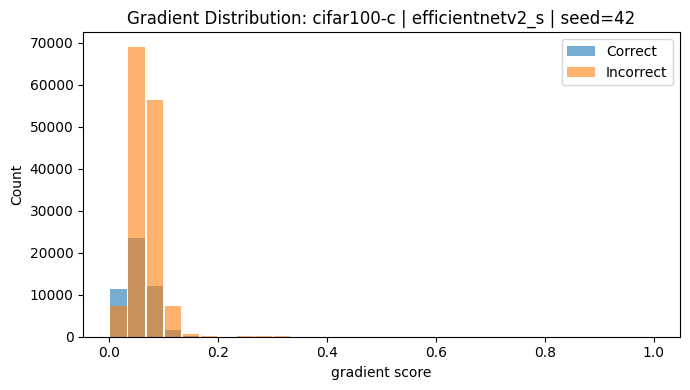

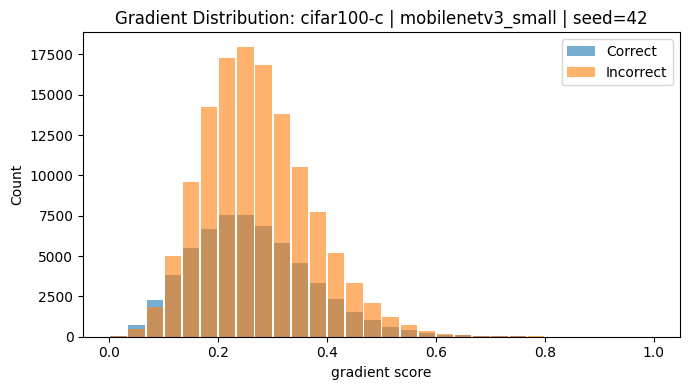

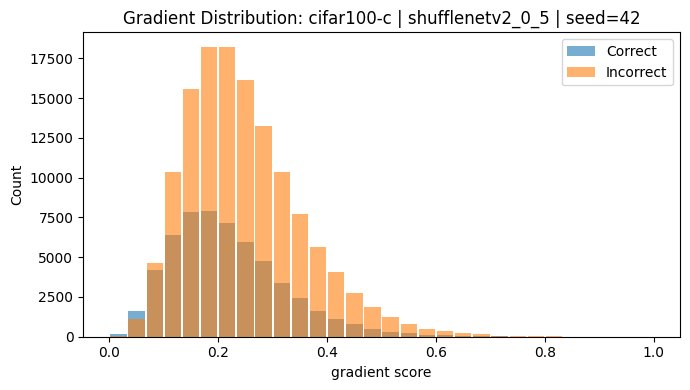

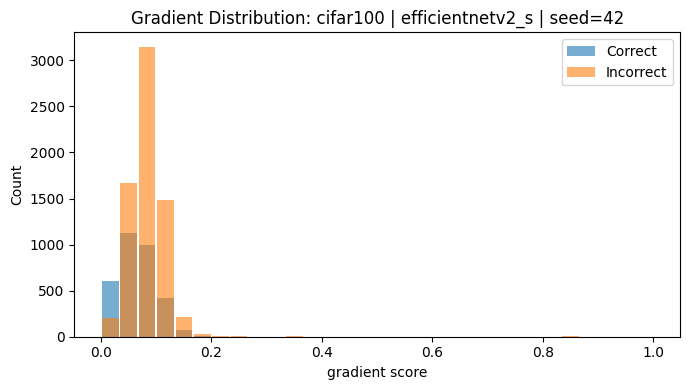

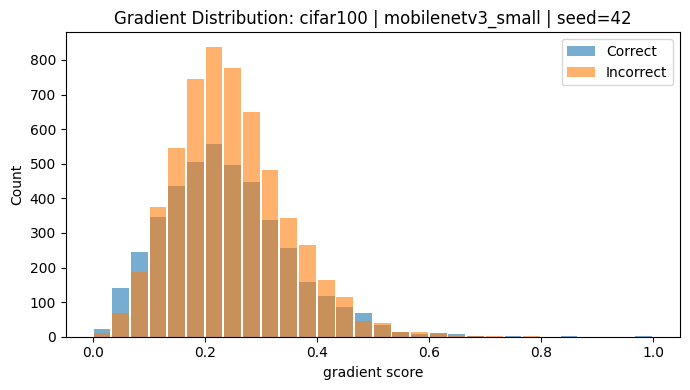

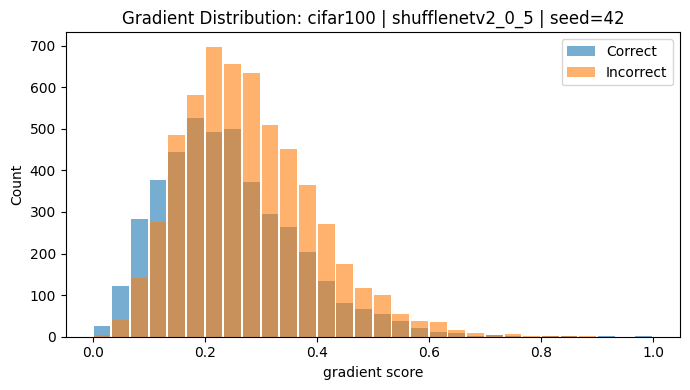

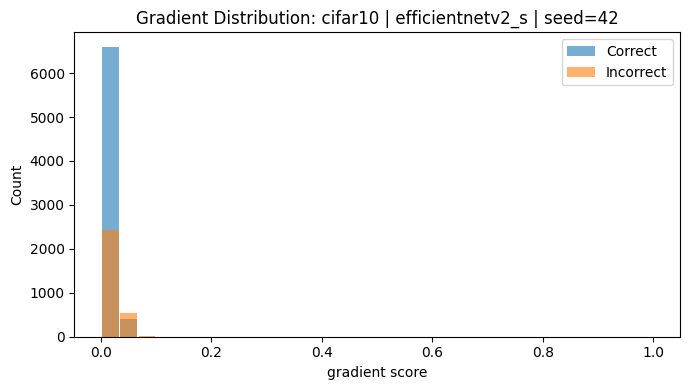

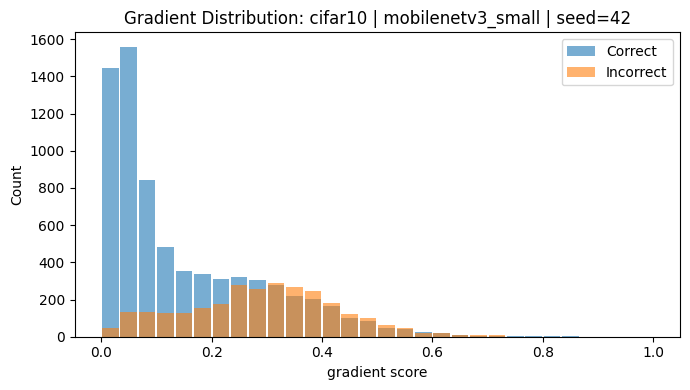

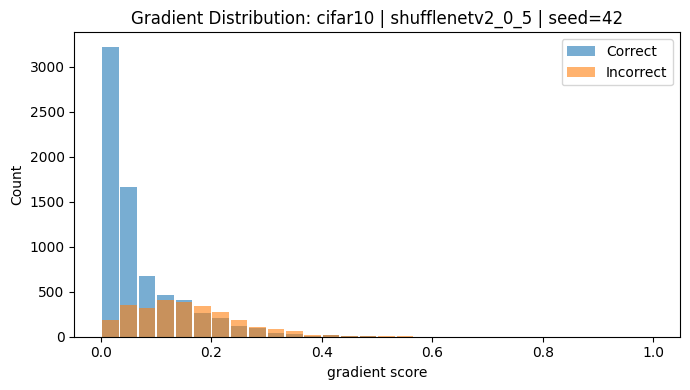

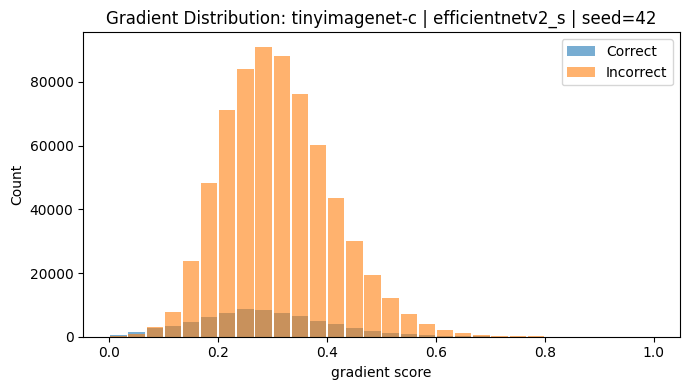

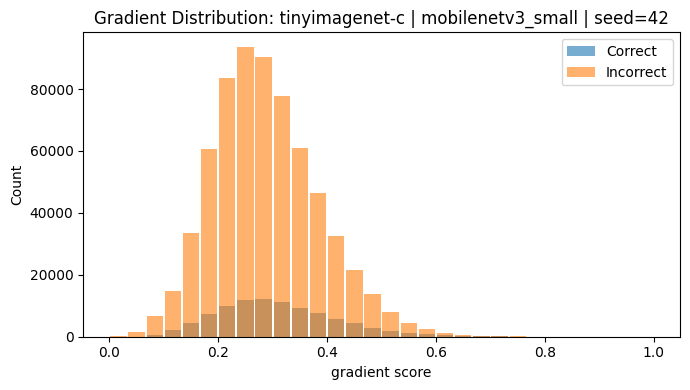

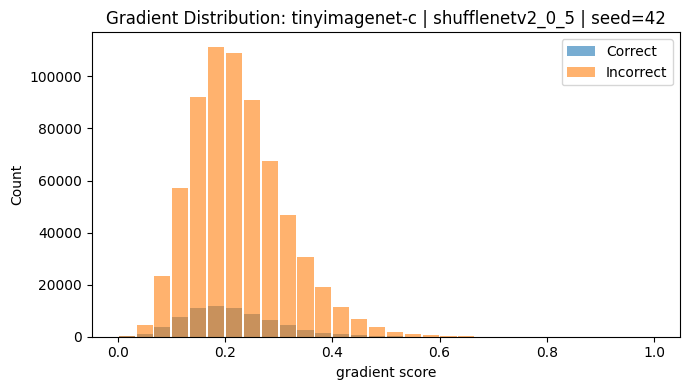

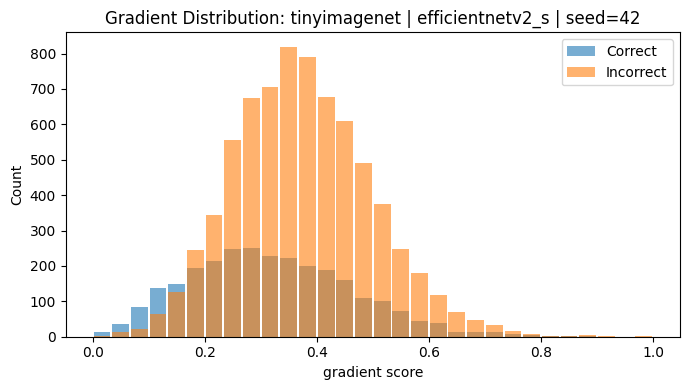

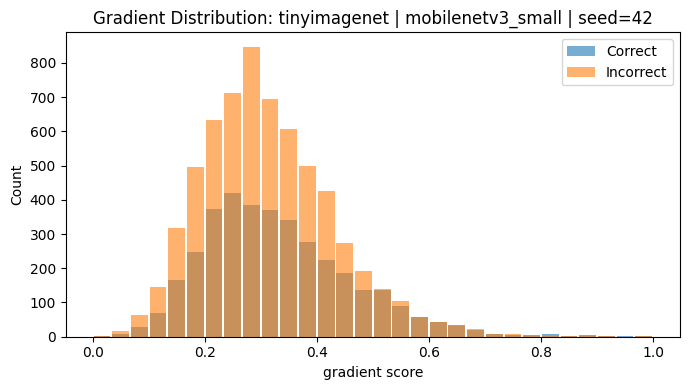

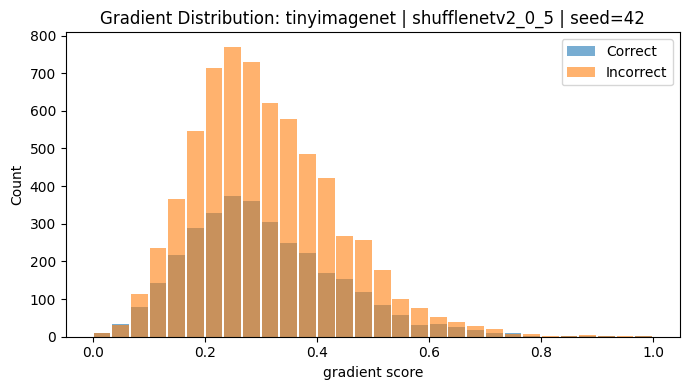

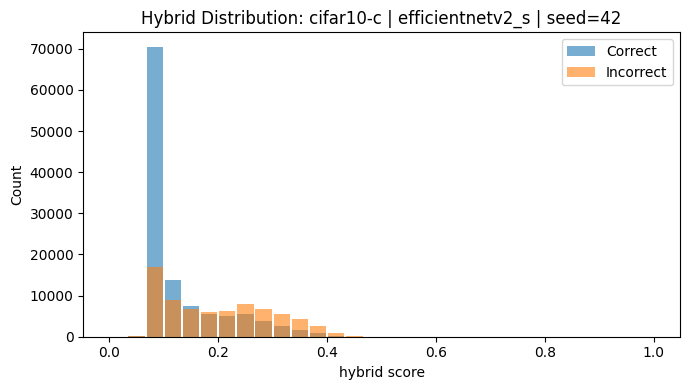

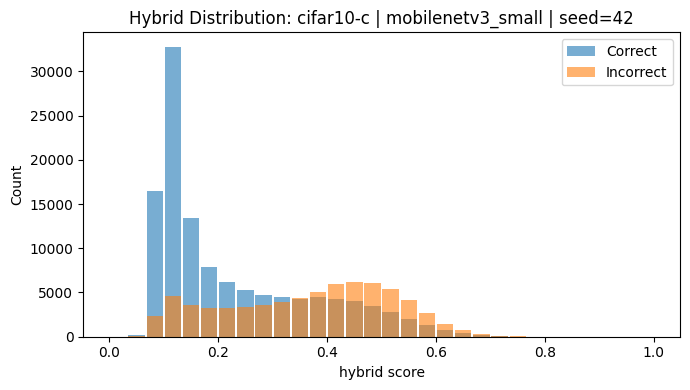

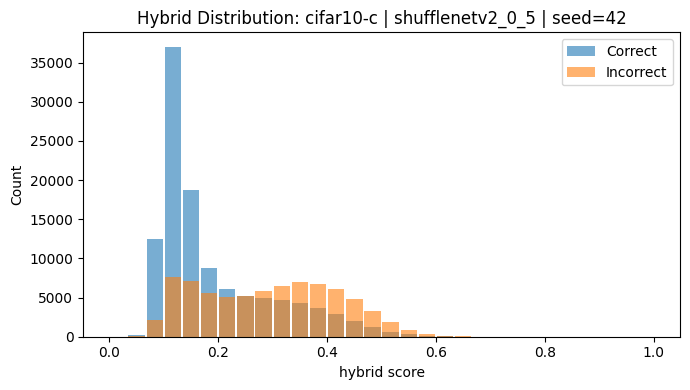

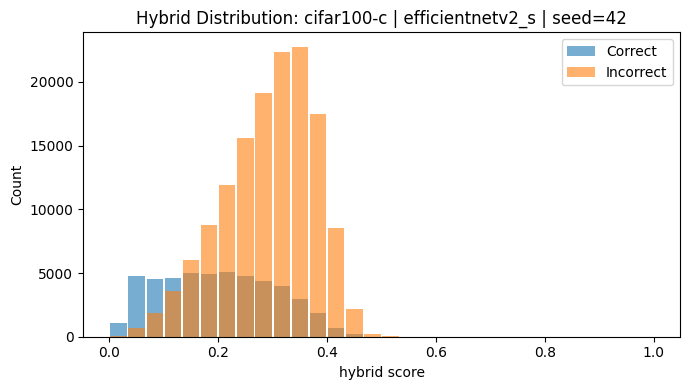

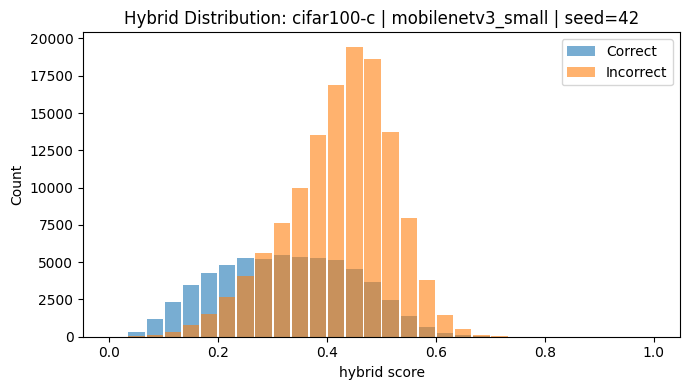

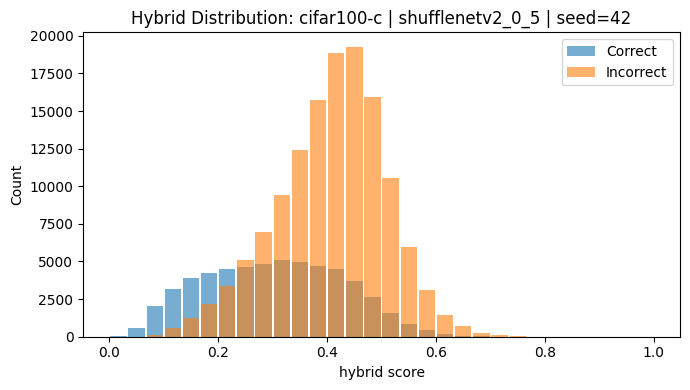

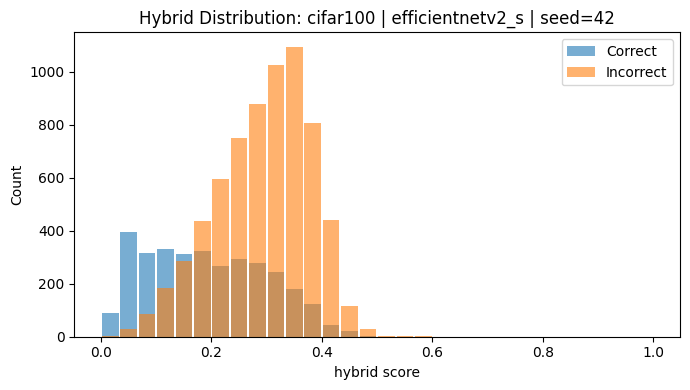

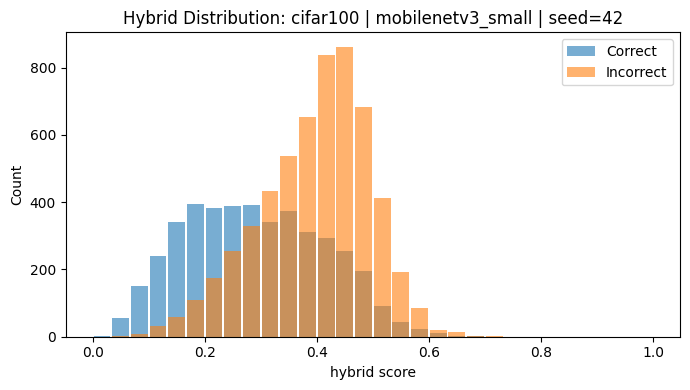

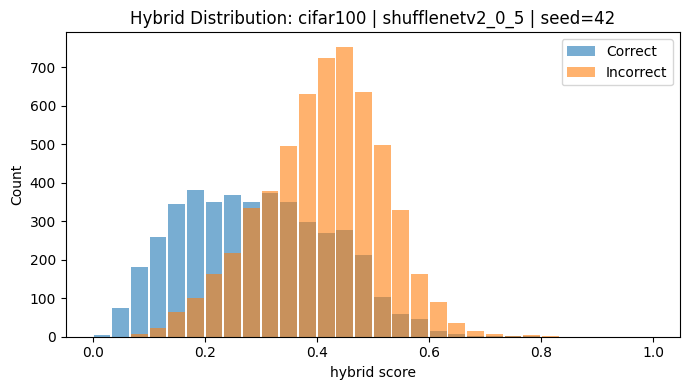

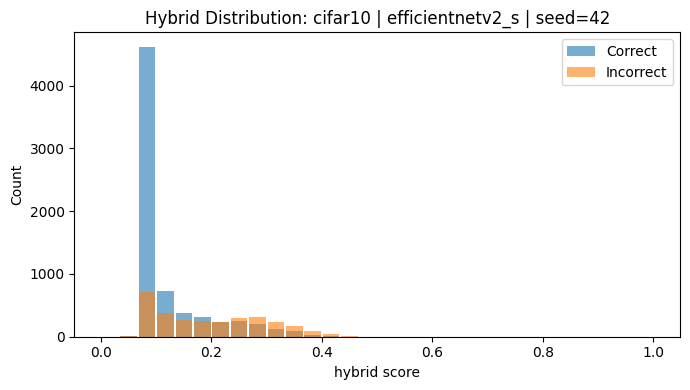

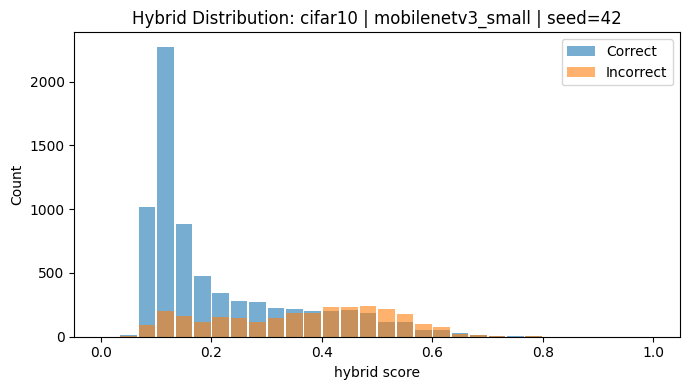

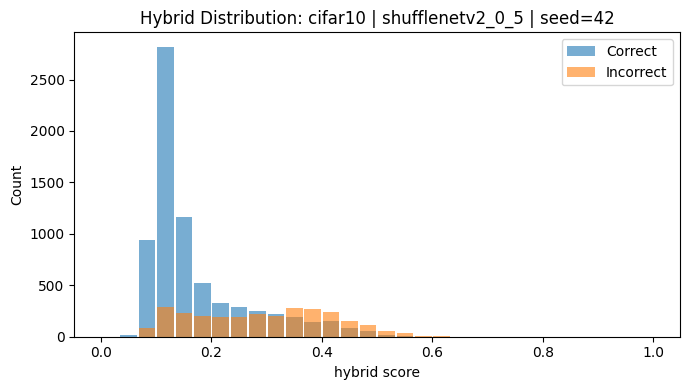

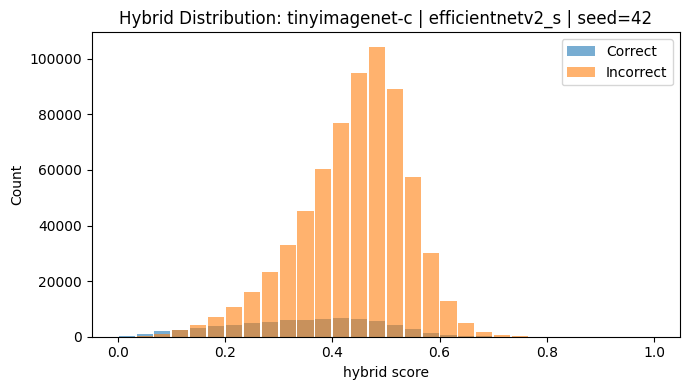

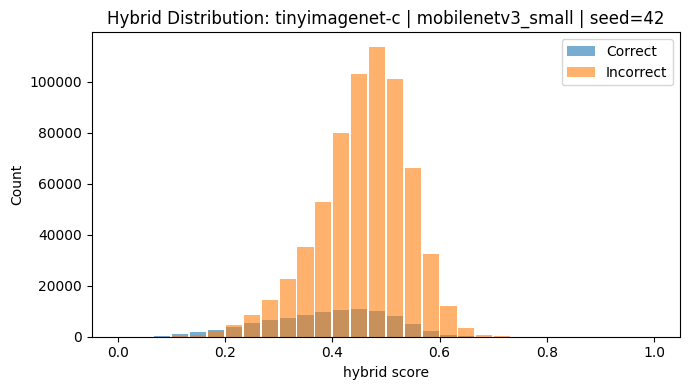

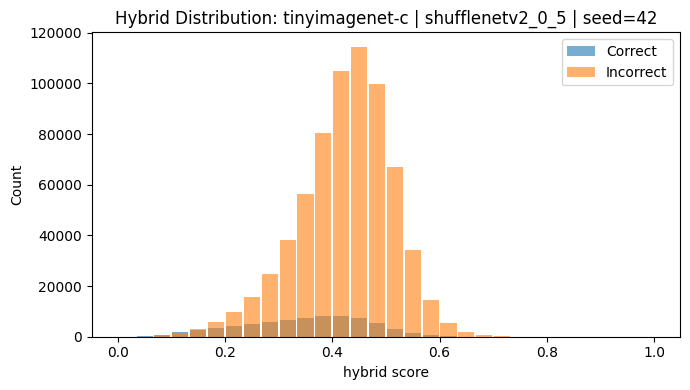

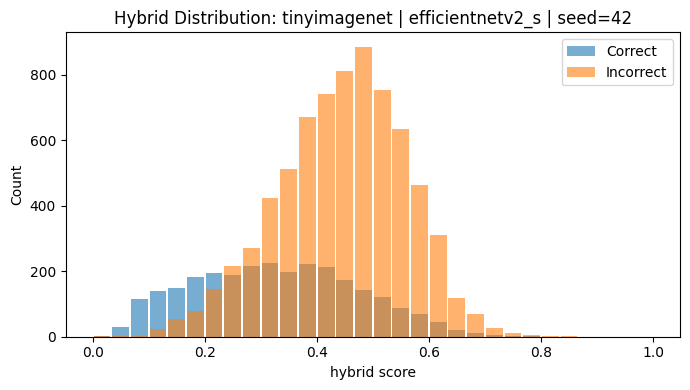

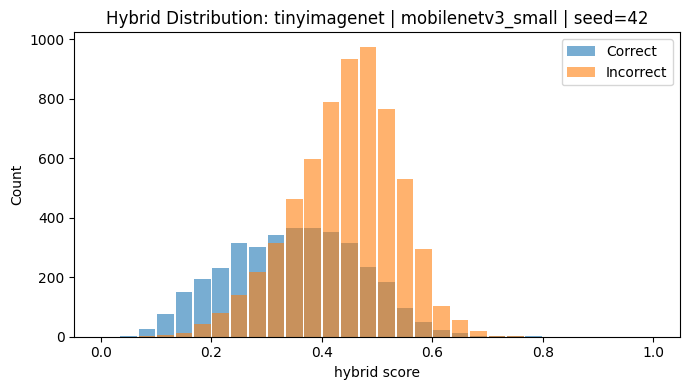

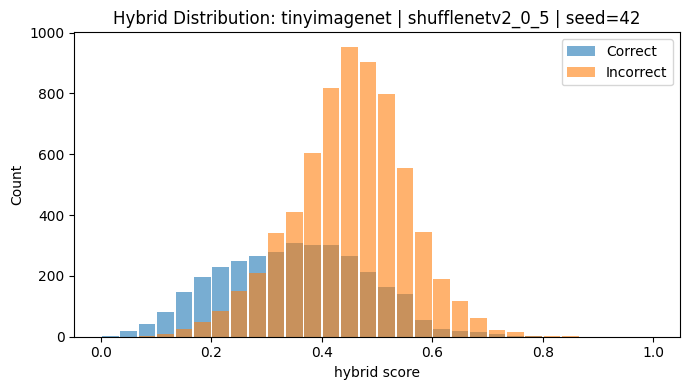

Saved score distribution histograms to: ./outputs/figures


In [16]:
def plot_score_distributions(runs, method="entropy"):
    for r in runs:
        sd_all = r.get("score_distributions", None)
        if sd_all is None or method not in sd_all:
            continue

        sd = sd_all[method]
        cfg = r["config"]
        dataset = cfg["dataset"]
        model = cfg["model_name"]
        seed = cfg.get("seed", None)

        edges = np.array(sd["edges"], dtype=float)
        correct_counts = np.array(sd["correct_counts"], dtype=float)
        incorrect_counts = np.array(sd["incorrect_counts"], dtype=float)

        centers = 0.5 * (edges[:-1] + edges[1:])
        width = (edges[1] - edges[0]) * 0.9

        plt.figure(figsize=(7, 4))
        plt.bar(centers, correct_counts, width=width, alpha=0.6, label="Correct")
        plt.bar(centers, incorrect_counts, width=width, alpha=0.6, label="Incorrect")

        plt.xlabel(f"{method} score")
        plt.ylabel("Count")
        plt.title(f"{method.capitalize()} Distribution: {dataset} | {model} | seed={seed}")
        plt.legend()

        out_path = os.path.join(FIG_DIR, f"hist_{method}_{dataset}_{model}_seed{seed}.png")
        plt.tight_layout()
        plt.savefig(out_path, dpi=200)
        plt.show()

# Generate all three
plot_score_distributions(runs, "entropy")
plot_score_distributions(runs, "gradient")
plot_score_distributions(runs, "hybrid")
print(f"Saved score distribution histograms to: {FIG_DIR}")

In [ ]:
# === Cardinality Transition Summary (AUROC) ===

import numpy as np
import matplotlib.pyplot as plt

# Map dataset to number of classes
class_map = {
    "cifar10": 10,
    "cifar100": 100,
    "tinyimagenet": 200
}

df = df_uncert.copy()
df["regime"] = np.where(df["dataset"].str.endswith("-c"), "corrupted", "clean")
df["dataset_base"] = df["dataset"].str.replace("-c", "", regex=False)
df["n_classes"] = df["dataset_base"].map(class_map)

# Keep only target datasets
df = df[df["dataset_base"].isin(class_map.keys())]

# Aggregate across models
summary = (
    df.groupby(["regime", "n_classes", "method"], as_index=False)["AUROC_error"]
    .mean()
)

fig, ax = plt.subplots(figsize=(7, 5))

for regime in ["clean", "corrupted"]:
    for method in ["entropy", "gradnorm", "hybrid"]:
        subset = summary[(summary["regime"] == regime) & (summary["method"] == method)]
        if subset.empty:
            continue
        ax.plot(
            subset["n_classes"],
            subset["AUROC_error"],
            marker="o",
            label=f"{method.capitalize()} ({regime})"
        )

ax.set_xlabel("Number of Classes")
ax.set_ylabel("AUROC (Error Detection)")
ax.set_title("AUROC vs Class Cardinality")
ax.set_ylim(0, 1)
ax.grid(alpha=0.3)
ax.legend()

save_fig(fig, "auroc_cardinality_transition")